In [2]:
!unzip -qq /content/santa/santa.zip

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import vgg19, VGG19_Weights
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from PIL import Image

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
def display_images(image_paths, title, max_images=4):
    plt.figure(figsize=(12, 3))
    for i, image_path in enumerate(image_paths[:max_images]):
        img = plt.imread(image_path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

In [5]:
categories = ['Train santa', 'Train normal', 'Val santa', 'Val normal', 'Test santa', 'Test normal']

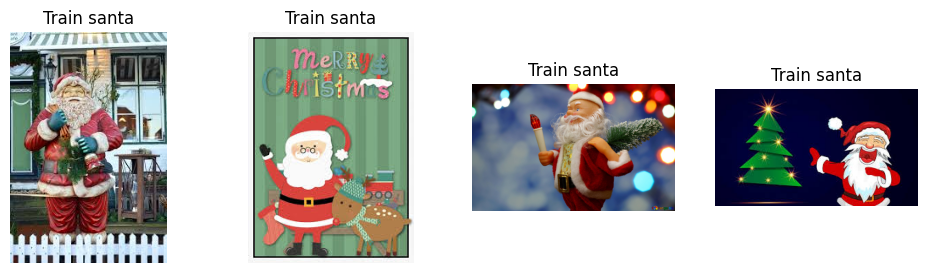

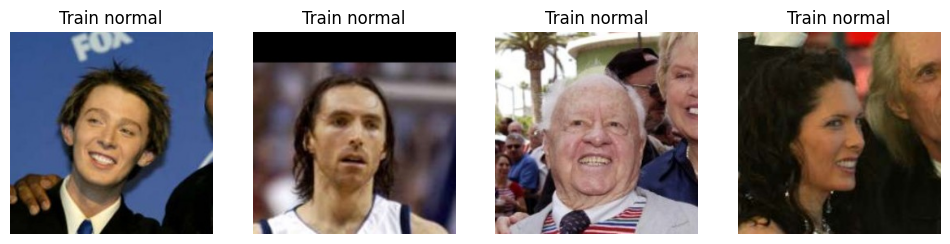

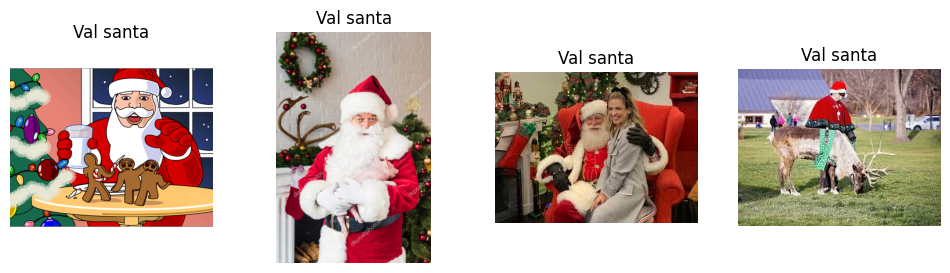

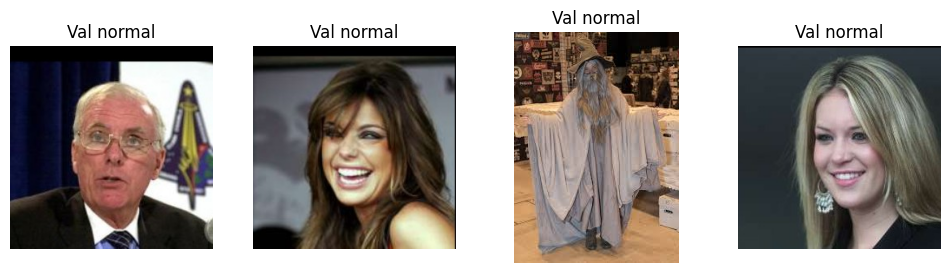

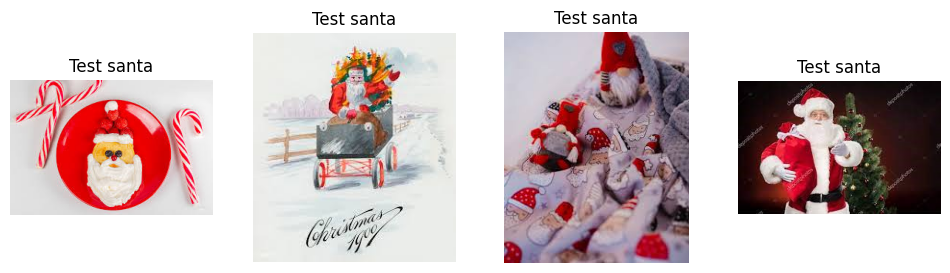

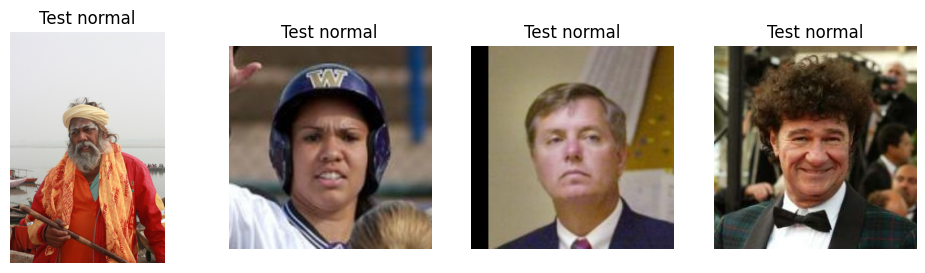

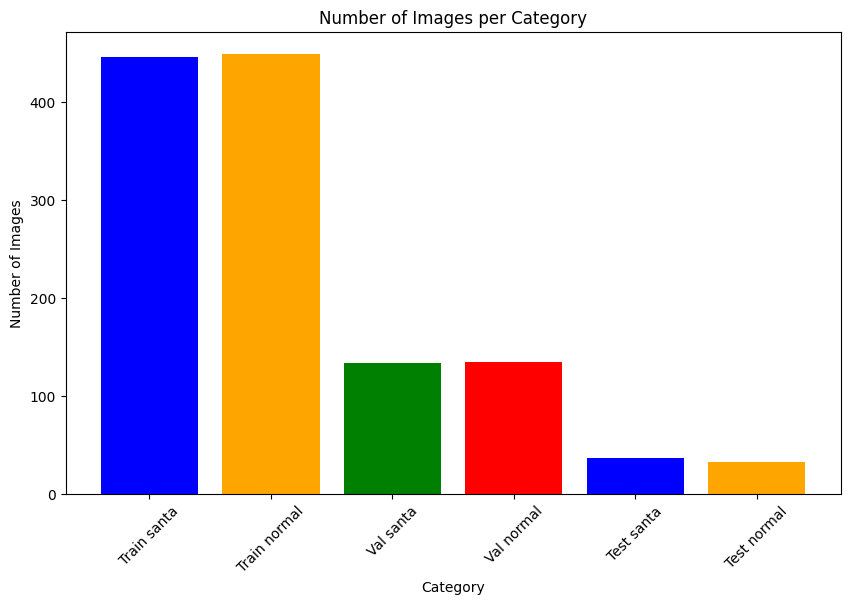

In [6]:
for category in categories:
    image_paths = glob.glob(f'/content/santa/{category.lower().replace(" ", "/")}/*')
    display_images(image_paths, category)
# 바 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'/content/santa/{category.lower().replace(" ", "/")}/*')) for category in categories], color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
train_path = '/content/santa/train'
val_path = '/content/santa/val'

In [9]:
train_dataset = ImageFolder(train_path, transform=transform)
val_dataset = ImageFolder(val_path, transform=transform)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [11]:
class VGG19(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG19, self).__init__()
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [12]:
pretrained_vgg19 = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 78.5MB/s]


In [13]:
model = VGG19(num_classes=1000)

In [14]:
# 사전학습된 모델의 features 부분에서 가중치 추출
pretrained_keys = set(pretrained_vgg19.features.state_dict().keys())

In [15]:
# 사전 학습된 모델에서 커스텀 모델로 가중치 복사
# strick = False : 이름이나 shape가 정확히 일치하는 것만 로드하고 나머지는 무시
# strick = True : 이름이나 shape가 다를경우, 에러발생
result = model.features.load_state_dict(pretrained_vgg19.features.state_dict(), strict=False)

In [16]:
# 커스텀 모델의 가중치를 features 부분에서 가중치를 추출
custom_keys = set(model.features.state_dict().keys())

In [17]:
# 복사된 가중치 (커스텀 모델과 사전학습된 모델의 교집합)
successfully_copied_keys = pretrained_keys.intersection(custom_keys)

# 커스텀 모델에만 있는 가중치
missing_keys = custom_keys - pretrained_keys

# 사전 학습된 모델에만 있는 가중치
unexpected_keys = pretrained_keys - custom_keys

print("복사된 가중치: ", successfully_copied_keys)
print("커스텀 모델에만 있는 가중치: ", missing_keys)
print("사전 학습된 모델에만 있는 가중치: ", unexpected_keys)

복사된 가중치:  {'32.bias', '0.bias', '7.bias', '19.weight', '34.weight', '21.weight', '25.weight', '14.bias', '23.bias', '25.bias', '5.weight', '28.bias', '30.weight', '10.bias', '2.weight', '16.bias', '28.weight', '16.weight', '7.weight', '30.bias', '12.weight', '34.bias', '5.bias', '2.bias', '19.bias', '10.weight', '21.bias', '14.weight', '23.weight', '12.bias', '0.weight', '32.weight'}
커스텀 모델에만 있는 가중치:  set()
사전 학습된 모델에만 있는 가중치:  set()


In [18]:
for param in model.features.parameters():
    param.requires_grad = False

In [19]:
model.classifier[6] = nn.Linear(4096, 1)

for param in model.classifier.parameters():
    param.requires_grad = True

In [20]:
model = model.to(device)
model

VGG19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [21]:
# BCE loss보다 나중에 나온 손실함수
criterion = nn.BCEWithLogitsLoss()

'''
시그모이드 함수를 내포함
<-> CrossEntropyLoss : 소프트맥스 함수를 내포
'''

'\n시그모이드 함수를 내포함\n<-> CrossEntropyLoss : 소프트맥스 함수를 내포\n'

In [22]:
def validate_model(model, val_loader, criterion):
    model.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # 레이블을 float 타입으로 변환 및 차원 맞춤
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [23]:
import torch.optim as optim
def train_model(optimizer_name, model, train_loader, val_loader, criterion, num_epochs=10):
    # optimizer설정
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.00001, betas=(0.9, 0.999))
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(model.parameters(), lr=0.00001, betas=(0.9, 0.999))
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")
    # 학습/검증 손실과 검증 정확도를 저장할 리스트
    train_losses = []
    val_losses = []
    val_accuracies = []
    for epoch in range(num_epochs):
        model.train()  # 모델을 학습 모드로 설정
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # 레이블을 float 타입으로 변환 및 차원 맞춤
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # 매 에포크마다 평균 학습 손실 계산
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        # 검증 손실 및 정확도 계산
        val_loss, val_accuracy = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')
    return train_losses, val_losses, val_accuracies

In [24]:
train_losses_Adam, val_losses_Adam, val_accuracies_Adam = train_model('Adam', model, train_loader, val_loader, criterion)

[Adam] Epoch 1, Train Loss: 0.437739, Val Loss: 0.220269, Validation Accuracy: 92.13%
[Adam] Epoch 2, Train Loss: 0.202621, Val Loss: 0.171064, Validation Accuracy: 92.51%
[Adam] Epoch 3, Train Loss: 0.147901, Val Loss: 0.135342, Validation Accuracy: 95.13%
[Adam] Epoch 4, Train Loss: 0.114969, Val Loss: 0.128313, Validation Accuracy: 95.88%
[Adam] Epoch 5, Train Loss: 0.077060, Val Loss: 0.111195, Validation Accuracy: 95.88%
[Adam] Epoch 6, Train Loss: 0.051592, Val Loss: 0.127946, Validation Accuracy: 94.38%
[Adam] Epoch 7, Train Loss: 0.043705, Val Loss: 0.120367, Validation Accuracy: 95.88%
[Adam] Epoch 8, Train Loss: 0.031151, Val Loss: 0.099044, Validation Accuracy: 96.25%
[Adam] Epoch 9, Train Loss: 0.022477, Val Loss: 0.102281, Validation Accuracy: 95.51%
[Adam] Epoch 10, Train Loss: 0.023001, Val Loss: 0.097161, Validation Accuracy: 95.51%


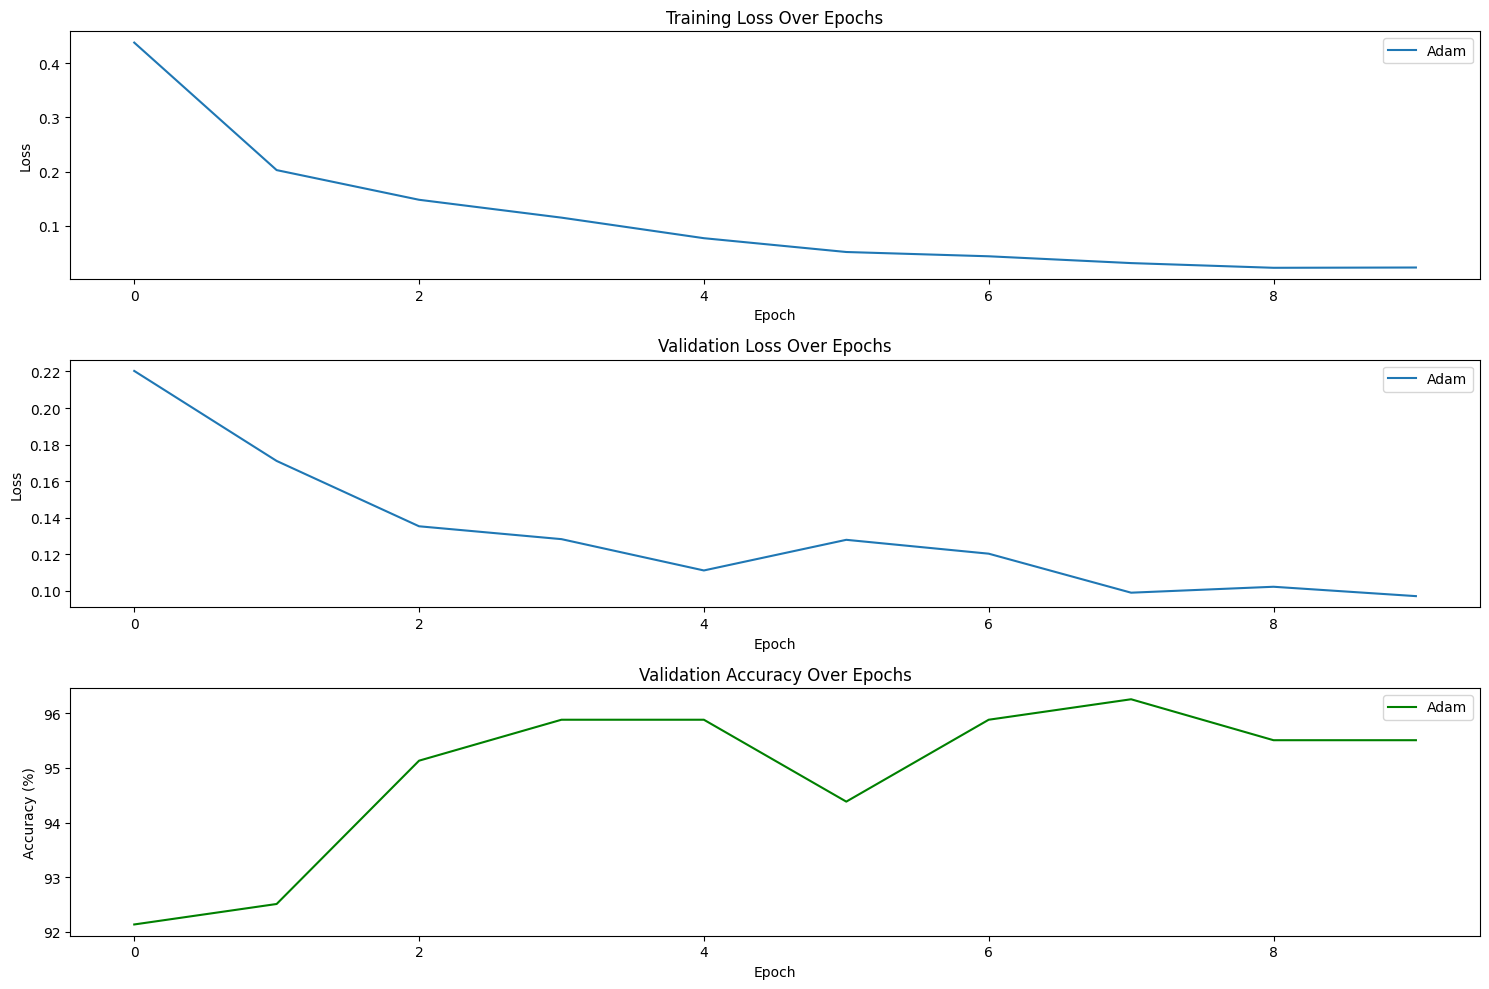

In [25]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))
# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_Adam, label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
# plt.ylim(0, 0.2)
# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_Adam, label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
# plt.ylim(0, 1.5)
# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_Adam, label='Adam', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
# plt.ylim(80, 100)
plt.tight_layout()
plt.show()

In [26]:
# Image load 및 tensor로 변환
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # 이미지를 모델에 맞게 변환하고 배치 차원 추가

In [31]:
class_folders = {
    'santa': '/content/santa/test/santa',
    'normal': '/content/santa/test/normal'
}
# 디바이스 설정 (GPU 사용 가능 여부 확인)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plt.figure(figsize=(20, 8))
counter = 1  # subplot 인덱스를 위한 카운터
# 각 클래스별로 5장의 이미지 추론 및 시각화
for class_name, folder_path in class_folders.items():
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[10:15]  # 첫 5장 선택
    for image_path in selected_paths:
        image = load_and_transform_image(image_path, transform)  # (1, C, H, W)
        image = image.to(device)
        model.eval()
        with torch.no_grad():
            output = model(image)  # 로짓 출력 (ex: tensor([[0.437]]))
            prob = torch.sigmoid(output)  # 확률화
            prediction = (prob >= 0.5).int().item()  # 0 또는 1
        pred_label = 'santa' if prediction == 1 else 'normal'
        # 결과 시각화
        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {pred_label}')
        plt.axis('off')
        counter += 1
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.